In [1]:
import os
import subprocess
import pandas as pd
import platform
import pathlib
import numpy as np
from annotations import *
from extract_video_features import *
from extract_audio_features import *
import cv2
import seaborn as sns
from scipy.stats import kurtosis, skew
from sklearn.metrics import f1_score
import importlib
from tqdm import tqdm
import ordinal_classification as o_c
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from util_Valentina import runGridSearchClassifiers


In [2]:
#get current directory
cwd = os.getcwd()

In [3]:
cwd

'/Users/valentinadiproietto/filrouge'

In [4]:
OpenFace_folder = '/Users/valentinadiproietto/OpenFace'
filename_annotations = 'https://docs.google.com/spreadsheets/d/1Rqu1sJiD-ogc4a6R491JTiaYacptOTqh6DKqhwTa8NA/gviz/tq?tqx=out:csv&sheet=Template'

In [5]:
Video_folder = '/Users/valentinadiproietto/Desktop/video_stress'

In [6]:
video_paths, video_names = get_videos(Video_folder)

In [7]:
video_names

['WIN_20210331_21_22_52_Pro',
 'WIN_20210329_14_13_45_Pro',
 'WIN_20210406_18_49_10_Pro',
 'WIN_20210408_14_11_32_Pro',
 'WIN_20210408_15_20_51_Pro',
 'WIN_20210404_10_58_27_Pro',
 'WIN_20210414_06_24_52_Pro',
 'WIN_20210406_15_06_15_Pro',
 'WIN_20210417_14_53_12_Pro',
 'WIN_20210413_15_38_01_Pro',
 'WIN_20210408_11_48_58_Pro',
 'WIN_20210408_16_04_32_Pro',
 'WIN_20210329_10_16_02_Pro',
 'WIN_20210323_19_17_40_Pro',
 'WIN_20210409_10_26_11_Pro',
 'Test_pour_AFPA',
 'WIN_20210405_15_09_16_Pro',
 'WIN_20210407_14_54_56_Pro_edit2',
 'WIN_20210406_21_05_52_Pro',
 'WIN_20210403_18_49_15_Pro',
 'WIN_20210408_14_02_19_Pro',
 'WIN_20210415_15_41_24_Pro',
 'WIN_20210406_18_35_52_Pro',
 'WIN_20210402_14_27_50_Pro',
 'WIN_20210407_09_04_05_Pro',
 'WIN_20210402_19_04_53_Pro',
 'WIN_20210416_08_06_54_Pro',
 'Video_1',
 'WIN_20210408_14_00_44_Pro',
 'WIN_20210404_21_41_12_Pro',
 'WIN_20210330_13_10_29_Pro']

In [8]:
list_dataframes = []
for i in video_names: 
    list_dataframes.append(create_dataframe_video('/Users/valentinadiproietto/OpenFace/processed/', i))


In [9]:
video_names.remove('WIN_20210329_14_13_45_Pro')
video_names.remove('WIN_20210402_14_27_50_Pro')


In [10]:
len(video_names)

29

In [11]:
list_df_max = []
for v_name in tqdm(video_names):
    df_annoted = get_df_video_with_annotations('/Users/valentinadiproietto/OpenFace/processed/', v_name, filename_annotations, "max")
    list_df_max.append(eliminate_features(df_annoted))


    

100%|██████████| 29/29 [02:22<00:00,  4.91s/it]


In [12]:
list_df_max[0].columns

Index(['frame', 'face_id', 'timestamp', 'confidence', 'success', 'AU01_r',
       'AU02_r', 'AU04_r', 'AU05_r', 'AU06_r', 'AU07_r', 'AU09_r', 'AU10_r',
       'AU12_r', 'AU14_r', 'AU15_r', 'AU17_r', 'AU20_r', 'AU23_r', 'AU25_r',
       'AU26_r', 'AU45_r', 'AU01_c', 'AU02_c', 'AU04_c', 'AU05_c', 'AU06_c',
       'AU07_c', 'AU09_c', 'AU10_c', 'AU12_c', 'AU14_c', 'AU15_c', 'AU17_c',
       'AU20_c', 'AU23_c', 'AU25_c', 'AU26_c', 'AU28_c', 'AU45_c', 'gaze_0_x',
       'gaze_0_y', 'gaze_0_z', 'gaze_1_x', 'gaze_1_y', 'gaze_1_z',
       'gaze_angle_x', 'gaze_angle_y', 'pose_Tx', 'pose_Ty', 'pose_Tz',
       'pose_Rx', 'pose_Ry', 'pose_Rz', 'type_candidat', 'sexe', 'video_name',
       'stress_global', 'stress', 'diapo'],
      dtype='object')

##

## AGGREGATION TIME WINDOW AND FIRST RF ON TIME WINDOW %

In [12]:
df_with_deriv = []
for i in list_df_max:
    to_drop = ['frame','face_id','timestamp','confidence','success', 'type_candidat']
    i = add_frameTimeWindow(i)
    i = i.drop(to_drop, axis = 1)
    i = add_derivatives_drop_spatial(i)
    df_with_deriv.append(i)

In [13]:
groupby_features= ['video_name','stress_global','stress','frameTimeWindow','sexe', 'diapo']

df_total = pd.concat(df_with_deriv)


In [14]:
df_total = df_total.groupby(groupby_features).agg(['mean']).reset_index()
df_total.columns= df_total.columns.map('_'.join).str.strip('_')
df_total[['stress']].value_counts()

stress
1.0       2419
0.0       2064
2.0        638
3.0         20
dtype: int64

In [15]:
x = df_total.drop(['video_name','stress_global', 'stress','frameTimeWindow'], axis = 1)
x.shape

(5141, 99)

In [16]:
#Replace string values
x.sexe = x.sexe.replace('H',0)
x.sexe = x.sexe.replace('F',1)

y = df_total[['stress']]
y.shape

(5141, 1)

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut

models_list = [RandomForestClassifier(random_state = 42, n_jobs=-1)]
parameters_list = [
                {'n_estimators': [100, 150, 200, 250, 300], 'max_depth':[10, 15, 20, 25,30], 'class_weight':[None,'balanced']}
                ]
groups = df_total['video_name']
loo = LeaveOneGroupOut()
cv_loo = loo.split(x, y, groups)

In [18]:
best_result, y_predict, y_proba, result_list = runGridSearchClassifiers(x, y, cv_loo, models_list, parameters_list, output_predict=True, n_jobs=-1, verbose=True)

Fitting 29 folds for each of 50 candidates, totalling 1450 fits
Best estimator RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       n_jobs=-1, random_state=42)
Best results 0.47420589324789425
Best params {'class_weight': 'balanced', 'max_depth': 10, 'n_estimators': 200}
accuracy (mean, std) 0.49188136107141134 0.18732930193915623
f1 (mean, std) 0.47420589324789425 0.19976346176406967
balanced accuracy (mean, std) 0.476389246580685 0.15440475243427615
precision (mean, std) 0.6255117618166157 0.18639492327844862
recall (mean, std) 0.49188136107141134 0.18732930193915623

f1_score (weighted) 0.4487367458086715
accuracy 0.4835635090449329


In [19]:
# Saving predictions
predict5s = pd.concat([df_total[['video_name','diapo','frameTimeWindow']],
                        pd.DataFrame(y_predict, columns=['ypredict'])],axis=1)


In [20]:
best_result

{'best_estimator': RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                        n_jobs=-1, random_state=42),
 'best_score': 0.47420589324789425,
 'best_params': {'class_weight': 'balanced',
  'max_depth': 10,
  'n_estimators': 200},
 'mean_test_f1_score': 0.47420589324789425,
 'std_test_f1_score': 0.19976346176406967,
 'mean_test_accuracy_score': 0.49188136107141134,
 'std_test_accuracy_score': 0.18732930193915623,
 'mean_test_balanced_accuracy_score': 0.476389246580685,
 'std_test_balanced_accuracy_score': 0.15440475243427615,
 'mean_test_precision': 0.6255117618166157,
 'std_test_precision': 0.18639492327844862,
 'mean_test_recall': 0.49188136107141134,
 'std_test_recall': 0.18732930193915623}

In [21]:
predict5s.to_csv('all_features_tw5.csv')

In [22]:
predict5s= pd.read_csv('all_features_tw5.csv')

## PIVOT TABLE WITH COUNT OF PREDICTION 5SEC, TO PREDICT STRESS BY DIAPO

In [23]:
X = predict5s.pivot_table(values='frameTimeWindow', columns='ypredict', index=['video_name','diapo'], aggfunc='count', fill_value=0)
X_sum = X.sum(axis=1).values.copy()
for col_number in range(len(X.columns)):
    X.iloc[:,col_number] = X.iloc[:,col_number] / X_sum
X
 

ypredict                              0.0       1.0  2.0
video_name                diapo                         
Test_pour_AFPA            1      0.323529  0.676471  0.0
                          8      0.600000  0.400000  0.0
                          9      0.550000  0.450000  0.0
                          10     0.400000  0.600000  0.0
                          11     0.500000  0.500000  0.0
...                                   ...       ...  ...
WIN_20210417_14_53_12_Pro 10     1.000000  0.000000  0.0
                          11     1.000000  0.000000  0.0
                          12     0.636364  0.363636  0.0
                          17     0.571429  0.428571  0.0
                          18     0.130435  0.869565  0.0

[232 rows x 3 columns]

In [24]:
#STRESS BY DIAPO

df_annotations_stress = pd.read_csv('annotations.csv')
df_annotations_stress = df_annotations_stress.drop(df_annotations_stress.columns[-1],axis=1).set_index('video_name').stack()
df_annotations_stress = pd.DataFrame(df_annotations_stress).reset_index()
df_annotations_stress.columns = ['video_name','diapo','stress']
#df_annotations_stress = df_annotations_stress.set_index(['video_name','diapo'])
df_annotations_stress['diapo'] = df_annotations_stress['diapo'].astype(int)
df_annotations_stress

,video_name,diapo,stress
0,Test_pour_AFPA,1,1.0
1,Test_pour_AFPA,8,1.0
2,Test_pour_AFPA,9,0.0
3,Test_pour_AFPA,10,0.0
4,Test_pour_AFPA,11,0.0
...,...,...,...
235,WIN_20210417_14_53_12_Pro,10,0.0
236,WIN_20210417_14_53_12_Pro,11,0.0
237,WIN_20210417_14_53_12_Pro,12,0.0
238,WIN_20210417_14_53_12_Pro,17,1.0


In [25]:
Xy = X.merge(df_annotations_stress, how='inner', on=['video_name','diapo'])
X = Xy.iloc[:,:-1].set_index(['video_name','diapo'])
y = Xy.iloc[:,-1]
Xy

,video_name,diapo,0.0,1.0,2.0,stress
0,Test_pour_AFPA,1,0.323529,0.676471,0.0,1.0
1,Test_pour_AFPA,8,0.600000,0.400000,0.0,1.0
2,Test_pour_AFPA,9,0.550000,0.450000,0.0,0.0
3,Test_pour_AFPA,10,0.400000,0.600000,0.0,0.0
4,Test_pour_AFPA,11,0.500000,0.500000,0.0,0.0
...,...,...,...,...,...,...
227,WIN_20210417_14_53_12_Pro,10,1.000000,0.000000,0.0,0.0
228,WIN_20210417_14_53_12_Pro,11,1.000000,0.000000,0.0,0.0
229,WIN_20210417_14_53_12_Pro,12,0.636364,0.363636,0.0,0.0
230,WIN_20210417_14_53_12_Pro,17,0.571429,0.428571,0.0,1.0


In [26]:
X

0.0       1.0  2.0
video_name                diapo                         
Test_pour_AFPA            1      0.323529  0.676471  0.0
                          8      0.600000  0.400000  0.0
                          9      0.550000  0.450000  0.0
                          10     0.400000  0.600000  0.0
                          11     0.500000  0.500000  0.0
...                                   ...       ...  ...
WIN_20210417_14_53_12_Pro 10     1.000000  0.000000  0.0
                          11     1.000000  0.000000  0.0
                          12     0.636364  0.363636  0.0
                          17     0.571429  0.428571  0.0
                          18     0.130435  0.869565  0.0

[232 rows x 3 columns]

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', LogisticRegression(multi_class='multinomial', fit_intercept=True, random_state=42))])

models_list = [
                LogisticRegression(multi_class='multinomial', fit_intercept=True, random_state=42),
                Pipeline(steps=[('pca', pca), ('logistic', LogisticRegression(multi_class='multinomial', fit_intercept=True))]),
                KNeighborsClassifier(),
                Pipeline(steps=[('pca', pca), ('knn', KNeighborsClassifier())]),
                RandomForestClassifier(random_state = 42, n_jobs=-1)
                ]

parameters_list = [
                    {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4 , 5, 10], 'class_weight' : [None, 'balanced']},
                    {'pca__n_components': [1, 2, 3, 4],
                        'logistic__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4 , 5, 10], 'logistic__class_weight' : [None, 'balanced']},
                    {'n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11, 12,  15, 20], 'weights' : ['uniform', 'distance'], 'p': [1, 2]},
                    {'pca__n_components': [1, 2, 3, 4],
                        'knn__n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11, 12,  15, 20], 'knn__weights' : ['uniform', 'distance'],                              'knn__p': [1, 2]},
                    {'n_estimators': [50, 100, 150, 200], 'max_depth':[3, 4, 5, 6, 10, 15, 20], 'class_weight':[None,'balanced']}
                    ]

groups = X.reset_index()['video_name']
loo = LeaveOneGroupOut()
cv_loo = loo.split(X, y, groups)

In [28]:
best_result_diapo, y_predict_diapo, y_proba, result_list_diapo = runGridSearchClassifiers(X, y, cv_loo, models_list, parameters_list,output_predict=True, n_jobs=-1, verbose=True)

Fitting 29 folds for each of 20 candidates, totalling 580 fits
Best estimator LogisticRegression(C=0.5, multi_class='multinomial', random_state=42)
Best results 0.4502631946597464
Best params {'C': 0.5, 'class_weight': None}
accuracy (mean, std) 0.4870689655172414 0.22587193976851558
f1 (mean, std) 0.4502631946597464 0.24507700932117496
balanced accuracy (mean, std) 0.49332238642583465 0.2023952812941953
precision (mean, std) 0.5145371510673235 0.2997916521061077
recall (mean, std) 0.4870689655172414 0.22587193976851558

Fitting 29 folds for each of 80 candidates, totalling 2320 fits
Best estimator Pipeline(steps=[('pca', PCA(n_components=1)),
                ('logistic',
                 LogisticRegression(C=0.5, multi_class='multinomial'))])
Best results 0.45697080697080694
Best params {'logistic__C': 0.5, 'logistic__class_weight': None, 'pca__n_components': 1}
accuracy (mean, std) 0.5 0.24122532033850383
f1 (mean, std) 0.45697080697080694 0.2584963959521343
balanced accuracy (mean, 

In [29]:
best_result_diapo

{'best_estimator': KNeighborsClassifier(n_neighbors=8),
 'best_score': 0.4831291792498689,
 'best_params': {'n_neighbors': 8, 'p': 2, 'weights': 'uniform'},
 'mean_test_f1_score': 0.4831291792498689,
 'std_test_f1_score': 0.2248743491875704,
 'mean_test_accuracy_score': 0.47844827586206895,
 'std_test_accuracy_score': 0.21791766654766445,
 'mean_test_balanced_accuracy_score': 0.4724548440065681,
 'std_test_balanced_accuracy_score': 0.24421941651057838,
 'mean_test_precision': 0.6080716338259442,
 'std_test_precision': 0.25852849867401273,
 'mean_test_recall': 0.47844827586206895,
 'std_test_recall': 0.21791766654766445}

In [30]:
y_predict_diapo
##ATTENZIONE NON PREDICE MAI I 2

array([1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1.,
       1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
       1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       0., 1., 1., 0., 0.

## ORA SEMPRE PARTENDO DALLE PEDIZIONI DI  5 SECONDI FACCIO NEL AGGIUNGENDO MINMAX sulle predizioni e predico su diapo

In [31]:
predict5s['ypredict'].value_counts()

1.0    3342
0.0    1624
2.0     175
Name: ypredict, dtype: int64

In [32]:
from scipy.stats import kurtosis, skew

def percentil25(x): 
    return np.percentile(x, q=25)

def percentil75(x): 
    return np.percentile(x, q=75)

In [33]:
# Autre méthode
X_diapo_minmax = predict5s.groupby(['video_name','diapo']).agg({'ypredict':['mean','min','max', 'median', 'std', percentil25, percentil75, kurtosis, skew]})

In [34]:
X_diapo_minmax

ypredict                             \
                                     mean  min  max median       std   
video_name                diapo                                        
Test_pour_AFPA            1      0.676471  0.0  1.0    1.0  0.474858   
                          8      0.400000  0.0  1.0    0.0  0.516398   
                          9      0.450000  0.0  1.0    0.0  0.510418   
                          10     0.600000  0.0  1.0    1.0  0.507093   
                          11     0.500000  0.0  1.0    0.5  0.512989   
...                                   ...  ...  ...    ...       ...   
WIN_20210417_14_53_12_Pro 10     0.000000  0.0  0.0    0.0  0.000000   
                          11     0.000000  0.0  0.0    0.0  0.000000   
                          12     0.363636  0.0  1.0    0.0  0.488504   
                          17     0.428571  0.0  1.0    0.0  0.534522   
                          18     0.869565  0.0  1.0    1.0  0.344350   

                                                                             
                                percentil25 percentil75  kurtosis      skew  
video_name                diapo                                              
Test_pour_AFPA            1             0.0         1.0 -1.430830 -0.754434  
                          8             0.0         1.0 -1.833333  0.408248  
                          9             0.0         1.0 -1.959596  0.201008  
                          10            0.0         1.0 -1.833333 -0.408248  
                          11            0.0         1.0 -2.000000  0.000000  
...                                     ...         ...       ...       ...  
WIN_20210417_14_53_12_Pro 10            0.0         0.0 -3.000000  0.000000  
                          11            0.0         0.0 -3.000000  0.000000  
                          12            0.0         1.0 -1.678571  0.566947  
                          17            0.0         1.0 -1.916667  0.288675  
                          18            1.0         1.0  2.816667 -2.194691  

[232 rows x 9 columns]

In [35]:
#questo e' lo stress vero per diapositiva
y

0      1.0
1      1.0
2      0.0
3      0.0
4      0.0
      ... 
227    0.0
228    0.0
229    0.0
230    1.0
231    1.0
Name: stress, Length: 232, dtype: float64

In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', LogisticRegression(multi_class='multinomial', fit_intercept=True, random_state=42))])

models_list = [
                LogisticRegression(multi_class='multinomial', fit_intercept=True, random_state=42),
                Pipeline(steps=[('pca', pca), ('logistic', LogisticRegression(multi_class='multinomial', fit_intercept=True))]),
                KNeighborsClassifier(),
                Pipeline(steps=[('pca', pca), ('knn', KNeighborsClassifier())]),
                RandomForestClassifier(random_state = 42, n_jobs=-1)
                ]

parameters_list = [
                    {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4 , 5, 10], 'class_weight' : [None, 'balanced']},
                    {'pca__n_components': [1, 2, 3, 4],
                        'logistic__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4 , 5, 10], 'logistic__class_weight' : [None, 'balanced']},
                    {'n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11, 12,  15, 20], 'weights' : ['uniform', 'distance'], 'p': [1, 2]},
                    {'pca__n_components': [1, 2, 3, 4],
                        'knn__n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11, 12,  15, 20], 'knn__weights' : ['uniform', 'distance'],                              'knn__p': [1, 2]},
                    {'n_estimators': [50, 100, 150, 200], 'max_depth':[3, 4, 5, 6, 10, 15, 20], 'class_weight':[None,'balanced']}
                    ]

groups = X_diapo_minmax.reset_index()['video_name']
loo = LeaveOneGroupOut()
cv_loo = loo.split(X_diapo_minmax, y, groups)

In [37]:
best_result_diapo_minmax, y_predict_diapo_minmax, y_proba, result_list_diapo = runGridSearchClassifiers(X_diapo_minmax, y, cv_loo, models_list, parameters_list,output_predict=True, n_jobs=-1, verbose=True)

Fitting 29 folds for each of 20 candidates, totalling 580 fits
Best estimator LogisticRegression(C=0.1, multi_class='multinomial', random_state=42)
Best results 0.460538336184888
Best params {'C': 0.1, 'class_weight': None}
accuracy (mean, std) 0.4698275862068966 0.2492557292207062
f1 (mean, std) 0.460538336184888 0.26098815856442026
balanced accuracy (mean, std) 0.47452107279693484 0.2488807880828225
precision (mean, std) 0.5378694581280787 0.28830002124914145
recall (mean, std) 0.4698275862068966 0.2492557292207062

Fitting 29 folds for each of 80 candidates, totalling 2320 fits
Best estimator Pipeline(steps=[('pca', PCA(n_components=4)),
                ('logistic',
                 LogisticRegression(C=0.05, multi_class='multinomial'))])
Best results 0.4735252774045878
Best params {'logistic__C': 0.05, 'logistic__class_weight': None, 'pca__n_components': 4}
accuracy (mean, std) 0.4827586206896552 0.2701455106205586
f1 (mean, std) 0.4735252774045878 0.2847086205298866
balanced accur

In [38]:
best_result_diapo_minmax

{'best_estimator': Pipeline(steps=[('pca', PCA(n_components=3)),
                 ('knn', KNeighborsClassifier(n_neighbors=4))]),
 'best_score': 0.5317966516242378,
 'best_params': {'knn__n_neighbors': 4,
  'knn__p': 2,
  'knn__weights': 'uniform',
  'pca__n_components': 3},
 'mean_test_f1_score': 0.5317966516242378,
 'std_test_f1_score': 0.24849485505039412,
 'mean_test_accuracy_score': 0.5258620689655172,
 'std_test_accuracy_score': 0.23299796123688932,
 'mean_test_balanced_accuracy_score': 0.5079091406677614,
 'std_test_balanced_accuracy_score': 0.25100033424274154,
 'mean_test_precision': 0.6084000410509032,
 'std_test_precision': 0.2725007809854947,
 'mean_test_recall': 0.5258620689655172,
 'std_test_recall': 0.23299796123688932}

In [39]:
#è meglio arriva a predire i 2
y_predict_diapo_minmax

array([0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 2., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 2., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1.,
       0., 1., 0., 0., 1., 1., 0., 2., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 2., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0.

In [40]:
# Saving predictions
df_diapo_minmax = pd.concat([X_diapo_minmax.reset_index()[['video_name','diapo']],
                        pd.DataFrame(y_predict_diapo_minmax, columns=['ypredict'])],axis=1)

df_diapo_minmax.columns = ['video_name', 'diapo', 'ypredict']
df_diapo_minmax
df_diapo_minmax.to_csv('all_features_tw5_diapo_minmax.csv')

In [48]:
df_diapo_minmax = pd.read_csv('all_features_tw5_diapo_minmax.csv')
df_diapo_minmax.columns

Index(['Unnamed: 0', 'video_name', 'diapo', 'ypredict'], dtype='object')

In [49]:
df_diapo_minmax = df_diapo_minmax.drop('Unnamed: 0', axis = 1) 
df_diapo_minmax.to_pickle("video_best_diapo.pkl")

In [50]:
df_diapo_minmax

,video_name,diapo,ypredict
0,Test_pour_AFPA,1,0.0
1,Test_pour_AFPA,8,1.0
2,Test_pour_AFPA,9,1.0
3,Test_pour_AFPA,10,0.0
4,Test_pour_AFPA,11,1.0
...,...,...,...
227,WIN_20210417_14_53_12_Pro,10,0.0
228,WIN_20210417_14_53_12_Pro,11,0.0
229,WIN_20210417_14_53_12_Pro,12,0.0
230,WIN_20210417_14_53_12_Pro,17,0.0


## GLOBAL STRESS, UTILIZZANDO LE PREDIZIONI DI DIAPO MINMAX

In [5]:
stress_diapo_by_video = df_diapo_minmax.pivot_table(values='ypredict', columns='diapo',index='video_name',aggfunc='mean')
stress_diapo_by_video

diapo,1,8,9,10,11,12,17,18
video_name,,,,,,,,
Test_pour_AFPA,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0
Video_1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
WIN_20210323_19_17_40_Pro,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
WIN_20210329_10_16_02_Pro,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
WIN_20210330_13_10_29_Pro,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
WIN_20210331_21_22_52_Pro,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
WIN_20210402_19_04_53_Pro,1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
WIN_20210403_18_49_15_Pro,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
WIN_20210404_10_58_27_Pro,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [6]:
df_annotations_stress = pd.read_csv('annotations.csv')
df_annotations_stress = df_annotations_stress.set_index(['video_name'])
df_annotations_stress

,1,8,9,10,11,12,17,18,stress_global
video_name,,,,,,,,,
Test_pour_AFPA,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
Video_1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
WIN_20210323_19_17_40_Pro,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
WIN_20210329_10_16_02_Pro,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
WIN_20210330_13_10_29_Pro,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
WIN_20210331_21_22_52_Pro,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
WIN_20210402_14_27_50_Pro,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0
WIN_20210402_19_04_53_Pro,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0
WIN_20210403_18_49_15_Pro,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,2.0


In [7]:
Xy = stress_diapo_by_video.merge(df_annotations_stress.iloc[:,-1],how='inner',on='video_name')
X_global= Xy.iloc[:,:-1]
y_global = Xy.iloc[:,-1]

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA()

models_list = [
                LogisticRegression(multi_class='multinomial', fit_intercept=True, random_state=42),
                Pipeline(steps=[('pca', pca), ('logistic', LogisticRegression(multi_class='multinomial', fit_intercept=True))]),
                KNeighborsClassifier(),
                Pipeline(steps=[('pca', pca), ('knn', KNeighborsClassifier())]),
                RandomForestClassifier(random_state = 42, n_jobs=-1)
                ]

parameters_list = [
                    {'C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4 , 5, 10], 'class_weight' : [None, 'balanced']},
                    {'pca__n_components': [1, 2, 3, 4],
                        'logistic__C': [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4 , 5, 10], 'logistic__class_weight' : [None, 'balanced']},
                    {'n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11, 12,  15, 20], 'weights' : ['uniform', 'distance'], 'p': [1, 2]},
                    {'pca__n_components': [1, 2, 3, 4],
                        'knn__n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11, 12,  15, 20], 'knn__weights' : ['uniform', 'distance'],                              'knn__p': [1, 2]},
                    {'n_estimators': [50, 100, 150, 200], 'max_depth':[3, 4, 5, 6, 10, 15, 20], 'class_weight':[None,'balanced']}
                    ]



In [46]:
best_result_tw5_diapo_minmax_global, y_predict_tw5_diapo_minmax_global, y_proba, result_list = runGridSearchClassifiers(X_global, y_global, 5 , models_list, parameters_list, output_predict=True, n_jobs=-1, verbose=True)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best estimator LogisticRegression(C=2, class_weight='balanced', multi_class='multinomial',
                   random_state=42)
Best results 0.4688888888888889
Best params {'C': 2, 'class_weight': 'balanced'}
accuracy (mean, std) 0.5066666666666667 0.20044395171163878
f1 (mean, std) 0.4688888888888889 0.20176994600562076
balanced accuracy (mean, std) 0.47777777777777775 0.22933074933944772
precision (mean, std) 0.4677777777777778 0.23137805096667186
recall (mean, std) 0.5066666666666667 0.20044395171163878

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best estimator Pipeline(steps=[('pca', PCA(n_components=2)),
                ('logistic',
                 LogisticRegression(C=1, class_weight='balanced',
                                    multi_class='multinomial'))])
Best results 0.6235555555555555
Best params {'logistic__C': 1, 'logistic__class_weight': 'balanced', 'pca__n_components': 2}
accuracy (mean, s

In [47]:
best_result_tw5_diapo_minmax_global

{'best_estimator': Pipeline(steps=[('pca', PCA(n_components=3)),
                 ('knn', KNeighborsClassifier(n_neighbors=10))]),
 'best_score': 0.6804444444444444,
 'best_params': {'knn__n_neighbors': 10,
  'knn__p': 2,
  'knn__weights': 'uniform',
  'pca__n_components': 3},
 'mean_test_f1_score': 0.6804444444444444,
 'std_test_f1_score': 0.13701869747151346,
 'mean_test_accuracy_score': 0.6866666666666668,
 'std_test_accuracy_score': 0.1309792180292567,
 'mean_test_balanced_accuracy_score': 0.6888888888888889,
 'std_test_balanced_accuracy_score': 0.15153535218873174,
 'mean_test_precision': 0.7511111111111111,
 'std_test_precision': 0.16815630588793434,
 'mean_test_recall': 0.6866666666666668,
 'std_test_recall': 0.1309792180292567}

In [48]:
from sklearn.metrics import f1_score
print("F1 " + str(f1_score(y_global, y_predict_tw5_diapo_minmax_global, average='weighted')))
from sklearn.metrics import accuracy_score
print("Accuracy " + str(accuracy_score(y_global, y_predict_tw5_diapo_minmax_global)))

F1 0.6735278514588858
Accuracy 0.6896551724137931


In [49]:
y_predict_tw5_diapo_minmax_global

array([1., 1., 1., 1., 0., 1., 2., 1., 1., 0., 1., 2., 0., 1., 0., 0., 0.,
       0., 2., 0., 2., 0., 0., 0., 0., 1., 2., 1., 0.])

In [8]:
#seeing prediction
df_global_5tw_minmax = pd.concat([X_global.reset_index()[['video_name']],
                        pd.DataFrame(y_predict_tw5_diapo_minmax_global, columns=['y_predict_tw5_diapo_minmax_global'])],axis=1)

df_global_5tw_minmax.columns = ['video_name', 'y_predict_tw5_diapo_minmax_global']
df_global_5tw_minmax


NameError: name 'y_predict_tw5_diapo_minmax_global' is not defined

In [51]:
#SAving predictions
df_global_5tw_minmax.to_csv('all_features_tw5_diapo_minmax_global.csv')

In [11]:
predictions_best = pd.read_csv('all_features_tw5_diapo_minmax_global.csv')
predictions_best = predictions_best.drop("Unnamed: 0", axis = 1)

In [32]:
y_pred = predictions_best["y_predict_tw5_diapo_minmax_global"]

In [30]:
y_true = Xy.reset_index()['stress_global']

In [34]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[9, 1, 2],
       [1, 8, 0],
       [3, 2, 3]])

In [35]:
from sklearn.metrics import f1_score
print("F1 " + str(f1_score(y_true, y_pred, average='weighted')))
from sklearn.metrics import accuracy_score
print("Accuracy " + str(accuracy_score(y_true, y_pred)))

F1 0.6735278514588858
Accuracy 0.6896551724137931


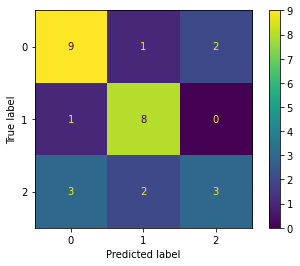

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(); 

In [55]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 21}
plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


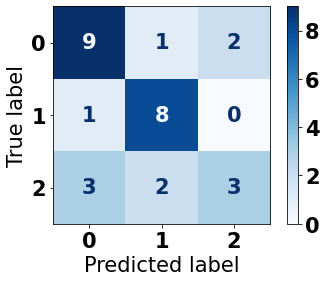

In [56]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[0,1,2])
disp = disp.plot(include_values=[0,1,2], cmap=plt.cm.Blues)